In [58]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import tensorflow as tf

Neural Network Model for Hyper Parameter Tuning

In [59]:
# Define the true objective function z = f(x, y)
def obj_func(x, y):
    return -(20 * (1 - np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))) - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np. pi * y))) + np.exp(1))

In [60]:

# Generate synthetic data for training the neural network
def generate_data():
    x = np.random.uniform(-35, 35, 1000)
    y = np.random.uniform(-35, 35, 1000)
    z = obj_func(x, y)
    return np.vstack((x, y)).T, z

# Generate the data
X, z = generate_data()

# Preprocess the data 
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Define the hyperparameter space
hyp_space  = [
    Integer(1, 5, name='num_layers'), # Num of layers in the network (depth)
    Integer(10, 100, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.0001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(10, 100, name='batch_size'), # Num of samples per batch
    Integer(1, 20, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

In [61]:
# Defining the neural network model
# def NN_model(num_layers, num_units, learning_rate, dropout_rate):
#     model = Sequential()
#     model.add(Dense(num_units, activation='relu', input_shape=(2,)))
#     for _ in range(num_layers - 1):
#         model.add(Dense(num_units, activation='relu'))
#         model.add(Dropout(dropout_rate))
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
#     return model

def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Define the objective function to minimize
@use_named_args(hyp_space)
def objective(**params):
    model = KerasRegressor(model=NN_model, **params, verbose=0)
    return -np.mean(cross_val_score(model, X, z, cv=3, n_jobs=-1, scoring='neg_mean_squared_error'))

# Perform Bayesian optimization
result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

# Output best hyperparameters from BayesOpt
print("Best hyperparameters:")
print("num_layers:", result.x[0])
print("num_units:", result.x[1])
print("learning_rate:", result.x[2])
print("dropout_rate:", result.x[3])
print("batch_size:", result.x[4])
print("epochs:", result.x[5])

# Train the model with the best hyperparameters on the entire dataset
best_model = KerasRegressor(
    model=NN_model,
    num_layers=result.x[0],
    num_units=result.x[1],
    learning_rate=result.x[2],
    dropout_rate=result.x[3],
    batch_size=result.x[4],
    epochs=result.x[5],
    verbose=1
)

# Fit the model
best_model.fit(X, z)

Best hyperparameters:
num_layers: 5
num_units: 42
learning_rate: 0.059090501416619236
dropout_rate: 0.0
batch_size: 10
epochs: 14
Epoch 1/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - loss: 85.8465 
Epoch 2/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 4.5623
Epoch 3/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 3.2141
Epoch 4/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 2.2469
Epoch 5/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 1.4662
Epoch 6/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 1.4214
Epoch 7/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 1.0863
Epoch 8/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 1.1533
Epoch 9/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 1.1219
Epoch 10/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 0.8223
Epoch 11/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.7560
Epoch 12/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.7983
Epoch 13/14
100/100 ━━━━━━━━━━━━━━━━━

KerasRegressor(
	model=<function NN_model at 0x000002683797A3E0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=14
	num_layers=5
	num_units=42
	learning_rate=0.059090501416619236
	dropout_rate=0.0
)

In [76]:
# Prepare the dataset for TensorFlow
X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
z_tf = tf.convert_to_tensor(z, dtype=tf.float32)

# Train the model
best_model.fit(X_tf, z_tf, epochs=result.x[5], batch_size=result.x[4], verbose=1)

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=100):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std

# Make predictions with MC Dropout
mean, std = mc_dropout_predictions(best_model, X_tf)

# Selecting new points with highest uncertainty
num_new_points = 10  # Num of new points to sample
new_points_indices = np.argsort(std)[-num_new_points:]
new_points = X[new_points_indices]

print("New points to sample:")
print(new_points)

Epoch 1/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - loss: 196.9501
Epoch 2/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 8.5926
Epoch 3/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 2.4466
Epoch 4/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 3.3303
Epoch 5/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 2.5038
Epoch 6/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 3.7082
Epoch 7/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 2.2934
Epoch 8/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 1.5247
Epoch 9/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 0.9700
Epoch 10/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 0.8810
Epoch 11/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 0.9287
Epoch 12/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.5627
Epoch 13/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 0.6043
Epoch 14/14
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 1.3710


TypeError: 'KerasRegressor' object is not callable

In [ ]:
# # Add dropout to the model
# def add_dropout(model, rate=0.5):
#     for layer in model.layers:
#         if isinstance(layer, Dropout):
#             layer.rate = rate
#     return model

# # Apply dropout during inference
# model_with_dropout = add_dropout(best_model.model_, rate=result.x[3])

# @tf.function
# def mc_dropout_predict(model, X, n_iter=100):
#     predictions = []
#     for _ in range(n_iter):
#         preds = model(X, training=True)
#         predictions.append(preds)
#     return tf.reduce_mean(predictions, axis=0), tf.math.reduce_std(predictions, axis=0)

# # Get predictions with uncertainty
# X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
# mean_pred, std_pred = mc_dropout_predict(model_with_dropout, X_tensor)
# mean_pred, std_pred = mean_pred.numpy(), std_pred.numpy()

# # Sort points by uncertainty
# uncertainty = std_pred
# sorted_indices = np.argsort(uncertainty)[::-1]  # Indices of points with highest uncertainty

# # Select top k uncertain points for new sampling
# k = 1
# new_points = X[sorted_indices[::k]]

# print("New points to sample:")
# print(new_points)

New points to sample:
[[[ -5.86827541 -34.36577793]]

 [[ -5.86827541 -34.36577793]]

 [[ -5.86827541 -34.36577793]]

 ...

 [[ -5.86827541 -34.36577793]]

 [[ -5.86827541 -34.36577793]]

 [[ -5.86827541 -34.36577793]]]


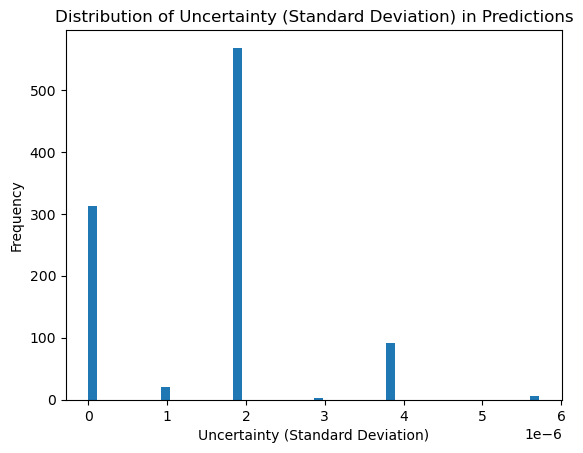

In [ ]:
import matplotlib.pyplot as plt

plt.hist(std_pred, bins=50)
plt.title("Distribution of Uncertainty (Standard Deviation) in Predictions")
plt.xlabel("Uncertainty (Standard Deviation)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Spliting data into training and testing sets
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=0)

# Train best model
best_model.fit(X_train, z_train)

# Evaluate best model
mse = best_model.score(X_test, z_test)
print("Model MSE:", mse)

Epoch 1/20


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 582us/step - loss: 56.4927  
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 24.1718
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 13.4884
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 3.8743
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 3.6924
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 3.0158
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 3.7400
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 2.6406
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 3.0595
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 2.6199
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 2.6180
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 2.6504
Epoch 13/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 2.0904
Epoch 14/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 1.7267
Epoch 15/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 2.

In [ ]:
import pandas as pd

df = pd.read_excel('Data/drone_Data.xlsx')

print(df.head())

   Maximum Principal Elastic Strain (m/m)  Total Deformation (m)  \
0                            1.645777e-08           1.194049e-09   
1                            1.462148e-08           1.061343e-09   
2                            1.278519e-08           9.286820e-10   
3                            1.096267e-08           7.960099e-10   
4                            9.174577e-09           6.633378e-10   

   Equivalent Elastic Strain (m/m) Dimensions (mm)  
0                     2.171072e-08     400*410*100  
1                     1.929829e-08     400*410*100  
2                     1.688586e-08     400*410*100  
3                     1.447343e-08     400*410*100  
4                     1.206215e-08     400*410*100  
